In [39]:
import numpy as np
import pandas as pd
import numpy.random as rnd
import matplotlib.pyplot as plt 
import scipy.linalg as lin
import re
import seaborn as sns

In [40]:
df= pd.read_excel(r'C:\xxxxx\xxxx\xxxxx\New_data.xlsx',sep=';')
df1=df.loc[:, (df != 0).any(axis=0)]
print(df1.shape)

(15671, 13)


In [41]:
X1 = df1.iloc[1:,[4]]
dataset = X1.astype('float32')
#print(dataset)
dataset['date'] = pd.date_range(start='1/1/2020', periods=len(dataset), freq='D')
dataset=dataset.set_index('date')

In [42]:
dataset.columns = dataset.columns.str.strip().str.lower().str.replace('[', '_').str.replace('.', '_').str.replace(']','_')
dataset.head()

,timeslices_4__profilerdataprocess_51__c0_us_
date,
2020-01-01,66.720001
2020-01-02,66.720001
2020-01-03,66.720001
2020-01-04,66.720001
2020-01-05,66.720001


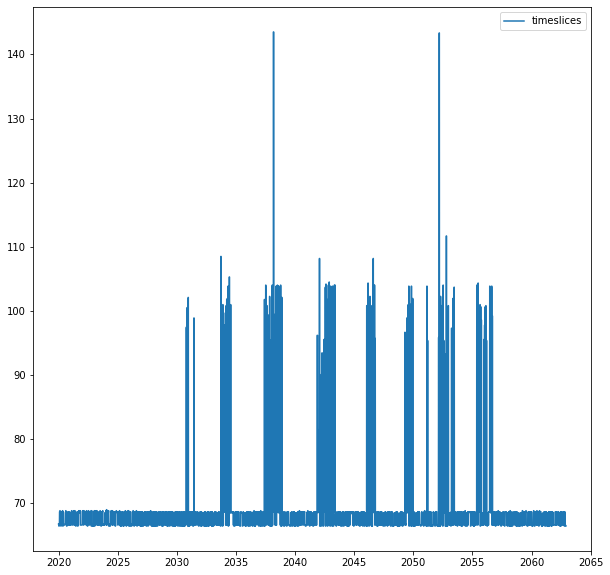

In [43]:
plt.figure(figsize=(10,10))
#sns.lineplot(data=X, dashes=False)
plt.plot(dataset, label='timeslices')
plt.legend();

In [44]:
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset.iloc[0:train_size], dataset.iloc[train_size:len(df)]
print(train.shape, test.shape)

(12536, 1) (3134, 1)


In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['timeslices_4__profilerdataprocess_51__c0_us_']])

train['timeslices_4__profilerdataprocess_51__c0_us_'] = scaler.transform(train[['timeslices_4__profilerdataprocess_51__c0_us_']])
test['timeslices_4__profilerdataprocess_51__c0_us_'] = scaler.transform(test[['timeslices_4__profilerdataprocess_51__c0_us_']])

c:\app\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\app\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [46]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [47]:
TIME_STEPS = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['timeslices_4__profilerdataprocess_51__c0_us_']], train.timeslices_4__profilerdataprocess_51__c0_us_, TIME_STEPS)
X_test, y_test = create_dataset(test[['timeslices_4__profilerdataprocess_51__c0_us_']], test.timeslices_4__profilerdataprocess_51__c0_us_, TIME_STEPS)

X_train.shape,X_test.shape

((12526, 10, 1), (3124, 10, 1))

In [48]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.LSTM( units=64,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64,return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 1)             65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
__________________________________________________

In [49]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Train on 11273 samples, validate on 1253 samples
Epoch 1/10
11273/11273 [==============================] - 10s 852us/sample - loss: 0.1618 - val_loss: 0.1817
Epoch 2/10
11273/11273 [==============================] - 5s 463us/sample - loss: 0.1099 - val_loss: 0.1593
Epoch 3/10
11273/11273 [==============================] - 5s 483us/sample - loss: 0.1037 - val_loss: 0.1677
Epoch 4/10
11273/11273 [==============================] - 6s 526us/sample - loss: 0.0989 - val_loss: 0.1609
Epoch 5/10
11273/11273 [==============================] - 6s 512us/sample - loss: 0.0982 - val_loss: 0.1613
Epoch 6/10
11273/11273 [==============================] - 6s 518us/sample - loss: 0.1036 - val_loss: 0.1611
Epoch 7/10
11273/11273 [==============================] - 6s 541us/sample - loss: 0.0988 - val_loss: 0.1538
Epoch 8/10
11273/11273 [==============================] - 6s 512us/sample - loss: 0.0962 - val_loss: 0.1588
Epoch 9/10
11273/11273 [==============================] - 6s 542us/sample - loss: 0.09

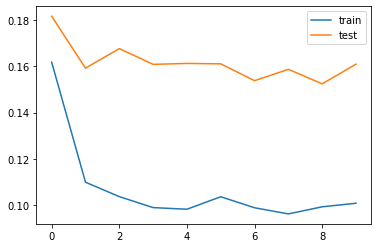

In [50]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [51]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

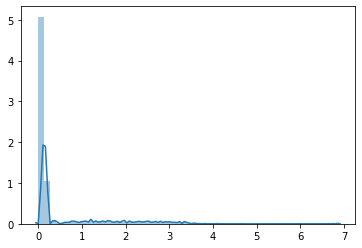

In [52]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [53]:

X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

#mean_loss = np.sum(test_mae_loss)/len(test_mae_loss)

In [54]:
print(test_mae_loss)

[[0.16229901]
 [0.13919797]
 [0.11629165]
 ...
 [0.00759417]
 [0.00656425]
 [0.00542093]]


In [63]:
def threshold(test_mae_loss):
    max_value=np.amax(test_mae_loss)
    threshold=max_value*0.8
    return threshold

In [64]:
THRESHOLD=threshold(test_mae_loss)

In [65]:
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['timeslices_4__profilerdataprocess_51__c0_us_'] = test[TIME_STEPS:].timeslices_4__profilerdataprocess_51__c0_us_


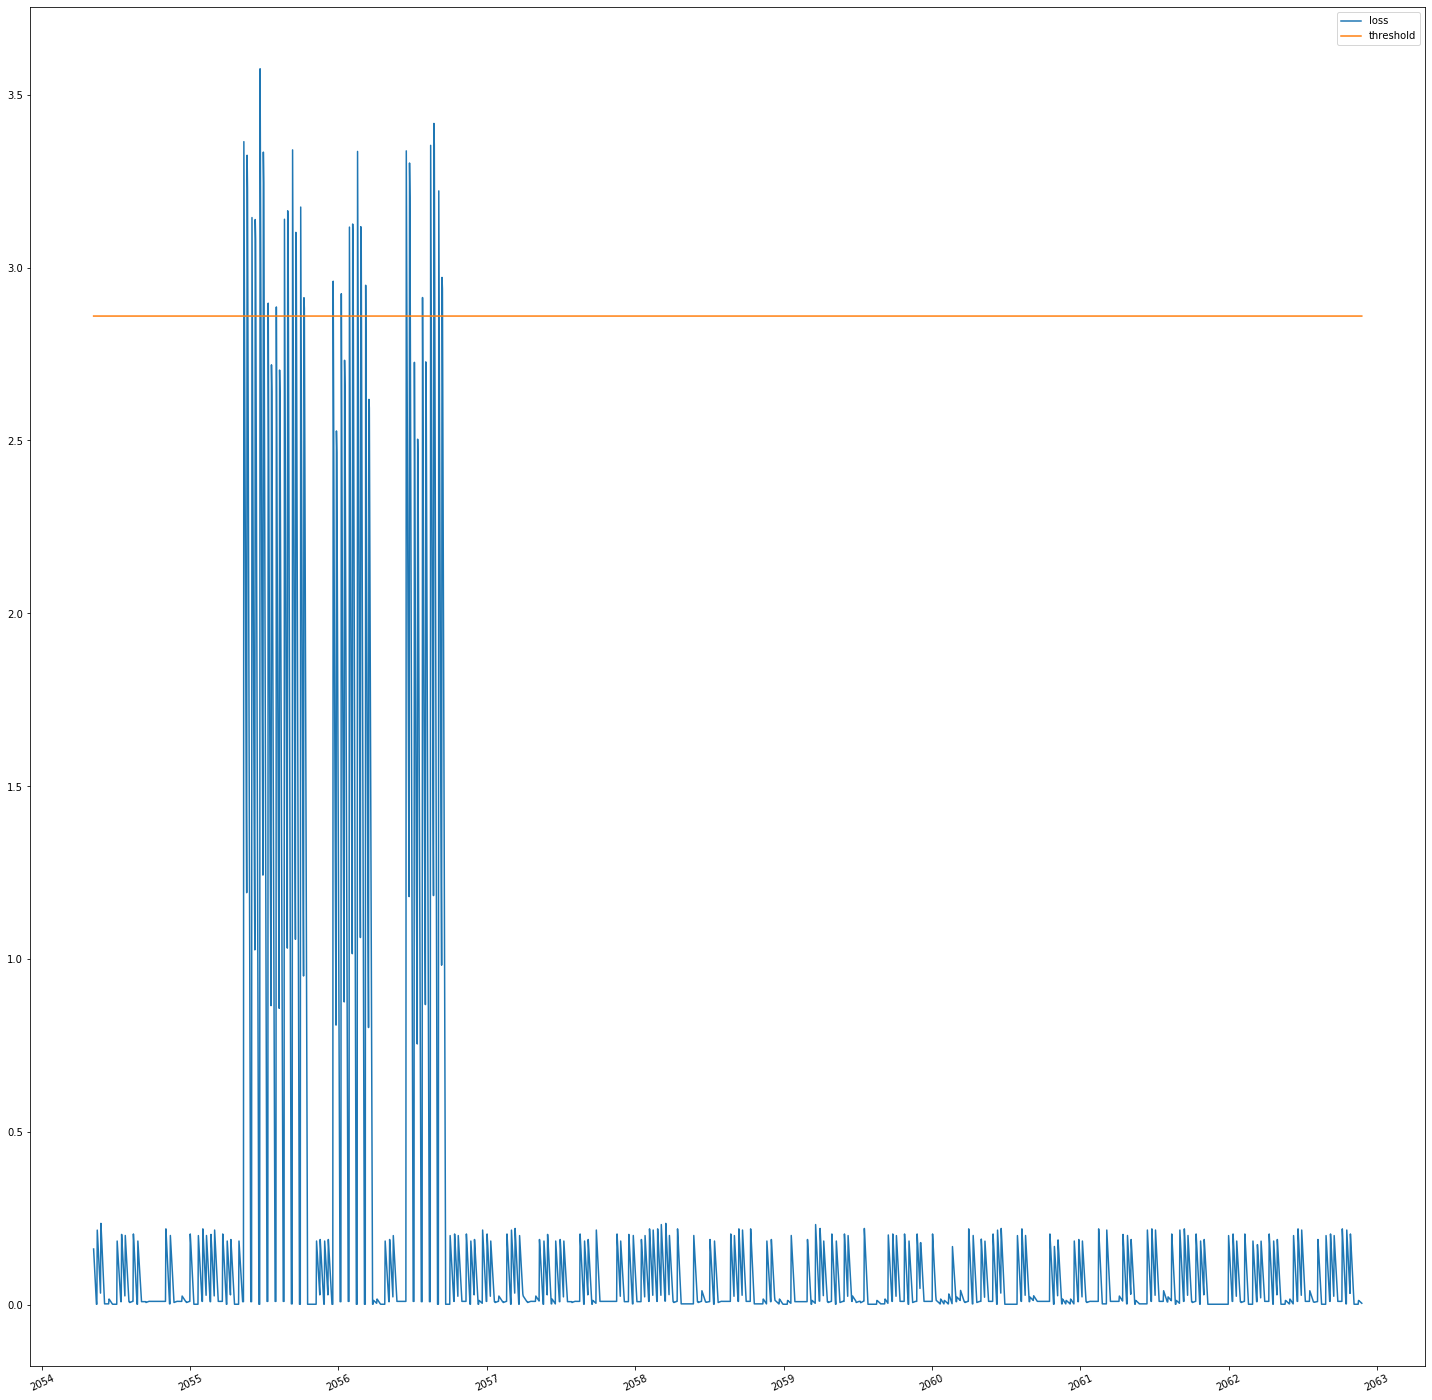

In [66]:
plt.figure(figsize=(25,25))
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [67]:

anomalies = test_score_df[test_score_df.anomaly == True]
print(anomalies)

                loss  threshold  anomaly  \
date                                       
2055-05-13  3.363948   2.859659     True   
2055-05-14  3.029866   2.859659     True   
2055-05-21  3.324568   2.859659     True   
2055-05-22  3.228249   2.859659     True   
2055-06-02  3.144382   2.859659     True   
2055-06-10  3.138706   2.859659     True   
2055-06-11  3.082171   2.859659     True   
2055-06-22  3.574574   2.859659     True   
2055-06-23  3.246503   2.859659     True   
2055-06-24  2.864533   2.859659     True   
2055-06-30  3.333654   2.859659     True   
2055-07-01  3.245012   2.859659     True   
2055-07-12  2.896905   2.859659     True   
2055-08-01  2.885922   2.859659     True   
2055-08-21  3.139541   2.859659     True   
2055-08-29  3.163947   2.859659     True   
2055-08-30  3.108034   2.859659     True   
2055-09-10  3.340137   2.859659     True   
2055-09-11  2.985807   2.859659     True   
2055-09-18  3.101596   2.859659     True   
2055-09-19  3.067830   2.859659 

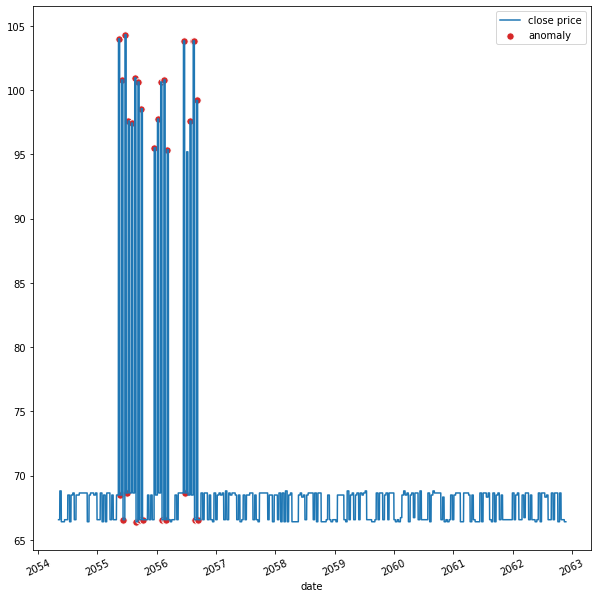

In [68]:
plt.figure(figsize=(10,10))
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].timeslices_4__profilerdataprocess_51__c0_us_), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies['timeslices_4__profilerdataprocess_51__c0_us_']),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();